The script is used to evaluate the error of PCE-----Created on 2021/05/12 by Qian Wang

In [6]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib import rc
# import latex
rc("text", usetex=False)

from basic.read_data import read_specify, file_settings
from basic.utils import dist_return

In [2]:
# Import settings of PCE
from error_fixing import fix_group_ranking
input_path = file_settings()[1]
output_path = file_settings()[0]
samples, values = read_specify('model', 'reduced', 
    product_uniform=False, num_vars=11)
samples_22, _ = read_specify('model', 'full', 
    product_uniform=False, num_vars=22)
values_vali = values[2000:]
samples_vali = samples[:, 2000:]
samples_22_vali = samples_22[:, 2000:]

In [3]:
# Calculate the error (RMSE) of PCE
product_uniform = ['exact', 'uniform', False] #, 'uniform'
rmse_all = {}
for p in product_uniform:
    dist_type = dist_return(p)
    filename = f'adaptive-reduce-{dist_type}_552'
    print(filename)
    approx_list_all = pickle.load(open(f'{output_path}{filename}-approx-list.pkl', "rb"))
    rmse_exact = pd.DataFrame(columns = np.arange(100, 2000, 50), index=np.arange(0, 100, 1))

    for key, value in approx_list_all.items():
        rmse_temp = []
        nsample = int(key.split('_')[1])
        if (nsample >= 100) and (nsample <= 2000):
            for pce in value:
                if dist_type == 'full':
                    y_hat = pce(samples_22_vali)
                else:
#                     breakpoint()
                    y_hat = pce(samples_vali)
                rmse_abs = (((y_hat.flatten()-values_vali.flatten())**2).mean())**0.5
                rmse_temp.append(rmse_abs / values_vali.std())
            rmse_exact.loc[0:(len(rmse_temp)-1), nsample] = rmse_temp
#     rmse_exact = pd.DataFrame.from_dict(rmse_exact)
    rmse_all[dist_type] = rmse_exact.mean(axis=0)
    rmse_all[dist_type + '_min'] = rmse_exact.min(axis=0)
    rmse_all[dist_type + '_max'] = rmse_exact.max(axis=0)

adaptive-reduce-exact_552
adaptive-reduce-uniform_552
adaptive-reduce-full_552


In [4]:
df = pd.DataFrame.from_dict(rmse_all).dropna()
df = df.reset_index()
df.tail(5)

,index,exact,exact_min,exact_max,uniform,uniform_min,uniform_max,full,full_min,full_max
14,1550,0.058758,0.058533,0.059022,0.061539,0.061290,0.061798,0.073159,0.072625,0.073838
15,1650,0.058819,0.058630,0.059317,0.073503,0.072816,0.074039,0.071000,0.070381,0.071853
16,1750,0.058703,0.058409,0.059031,0.062008,0.061788,0.062360,0.072888,0.072506,0.073128
17,1850,0.058878,0.058663,0.059219,0.061645,0.061491,0.061934,0.070156,0.069577,0.070656
18,2000,0.058746,0.058637,0.058972,0.077553,0.076447,0.084213,0.075483,0.075297,0.076466


<ipython-input-7-2ec5a574fe3c>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([int(i) for i in ax1.get_xticks()], rotation=90, fontsize=16);


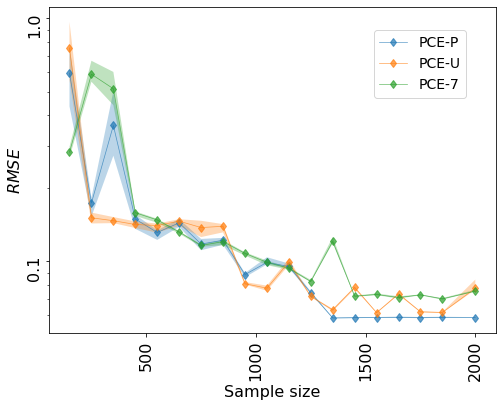

In [7]:
# Plot RMSE vs sample size
import matplotlib.ticker as mticker
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 6))
index_plot = np.array(np.arange(0, df.shape[0], 1))
xticks = [i for i in df['index'].values[index_plot]]
ax1 = df.iloc[index_plot].plot(x='index', y=df.columns[[1, 4, 7]], kind='line', marker='d',
                legend=True, logy=True, ax=axes, linewidth=0.7, alpha=0.7, logx=False)
for k in range(3):
    ax1.fill_between(df.loc[index_plot, 'index'], df.iloc[index_plot][df.columns[3*k + 2]].values, df.iloc[index_plot][df.columns[3*k + 3]].values, alpha=0.3)
ax1.legend(['PCE-P', 'PCE-U', 'PCE-7'], bbox_to_anchor=(0.95, 0.95), fontsize=14) # 'PCE-U',
ax1.set_ylabel(r'$RMSE$', fontsize = 16);
ax1.set_xlabel('Sample size', fontsize = 16);
ticks_loc = ax1.get_yticks().tolist()
ax1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax1.set_yticklabels(ax1.get_yticks(), rotation=90, fontsize=16);
ax1.set_xticklabels([int(i) for i in ax1.get_xticks()], rotation=90, fontsize=16);
# plt.savefig(f'{output_path}/figure/adaptive_independent_validation_log.png', dpi=300, format='png')

# plot the cross-validation RMSE

In [9]:

def df_return(fp, fn):
    error_stats = pd.read_csv(f'{fp}{fn}', index_col = 'index')
    cols = error_stats.columns
    error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
    error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
    df_temp = error_stats.iloc[:]
    
    return df_temp

In [10]:
# Plot errors of cross-validation
from matplotlib import rcParams

output_path = file_settings()[0]
filename = ['error_cv_exact_552.csv', 'error_cv_uniform_552.csv',  'error_cv_full_552.csv']

df_uniform = df_return(output_path[0], filename[0])
df_uniform = df_uniform.filter(items=['mean'])
cols = df_uniform.columns
df_uniform.rename(columns={col: col+'_exact' for col in cols if col == 'mean'}, inplace=True)
df_22 = df_return(output_path[0], filename[2])
df_22 = df_22.filter(items=['mean'])
df_22.rename(columns={col: col+'_22' for col in cols}, inplace=True)

df_exact = df_return(output_path[0], filename[1])
df_exact = df_exact.filter(items=['mean'])
df_exact.rename(columns={col: 'mean_uni' for col in cols}, inplace=True)

df = pd.concat([df_uniform, df_exact, df_22], axis=1)

df_cols = df.columns
keys = ['legend', 'legend_low', 'legend_up']
legend_dict = {}
for ind in range(len(keys)):
    legend_dict[keys[ind]] = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==ind]

df = df.reset_index()
# plt.savefig(f'{output_path}/figure/pce_compare.png', format='png', dpi=300)

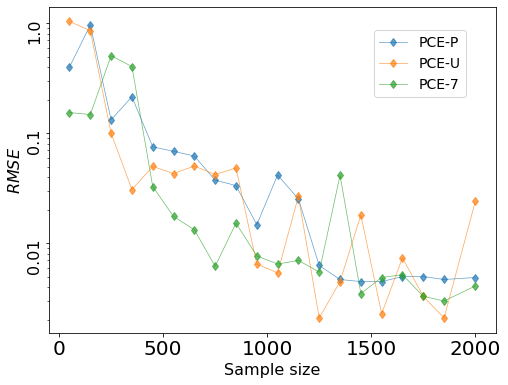

In [12]:
# Plot RMSE vs sample size
import matplotlib.ticker as mticker
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 6))
index_plot = np.array(np.arange(0, df.shape[0], 1))
xticks = [int(i.split('_')[1]) for i in df['index'].values[index_plot]]
df['index'] = xticks
ax1 = df.iloc[index_plot].plot(x='index', y=df.columns[[1, 2, 3]], kind='line', marker='d',
                legend=True, logy=True, ax=axes, linewidth=0.7, alpha=0.7, logx=False)

ax1.legend(['PCE-P', 'PCE-U', 'PCE-7'], bbox_to_anchor=(0.95, 0.95), fontsize=14) # 'PCE-U',
ax1.set_ylabel(r'$RMSE$', fontsize = 16);
ax1.set_xlabel('Sample size', fontsize = 16);
# ax1.set_xlim(1, 10000)
# ax1.set_xticklabels(xticks, rotation=90, fontsize=14);
ticks_loc = ax1.get_yticks().tolist()
ax1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax1.set_yticklabels(ax1.get_yticks(), rotation=90, fontsize=16);
# ax1.set_xticklabels([int(i) for i in ax1.get_xticks()], rotation=90, fontsize=16);
plt.savefig(f'{output_path}/figure/adaptive_cross_validation_log.png', dpi=300, format='png')